notes on 2020.2.10:
- pysteps result is calculated in a seperate shell. This notebook is only used for case checking

In [21]:
import glob
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
print(os.getcwd())

from rainymotion import models, metrics, utils
from collections import OrderedDict
import h5py
import wradlib.ipol as ipol
from datetime import datetime,timedelta
import pandas as pd
import joblib
data_folder = "/Users/jiang/data/jma_radar"
daily_folder = "/Users/jiang/data/jma_radar/2019_daily_unit8"
csv_path = os.path.join(data_folder,"threat_coverage.csv")
data0 = pd.read_csv(csv_path)

/Users/jiang/github_all/rainymotion/docs/notebooks


In [24]:
np.random.seed(1)  # only valid for once
select = np.random.choice(23508, 100).astype(np.int16)
select.sort()
print(data0.loc[select, "threat"].median())

0.50875727395838


In [25]:
%%time

time_step = 5 * 60 # seconds
threshold = 0.1  # mm/h
dt_threat = {}  # datetime: threat score

modela = models.Dense60()  
# default method is "DIS"
# default advection is "constant-vector"
daily_database = {}
inputs = np.zeros(shape = (2,1000,1000), dtype = np.float16)

a_threat = []

per_threat = []
for i in select:  
    dt =     datetime.strptime(data0.loc[i,"datetime"], '%Y-%m-%d %H:%M:%S')
    dt_now = dt + timedelta(seconds = time_step)
    dt_12  = dt + timedelta(seconds = time_step * 13)
    yday_str = dt.strftime('%Y_%m_%d')    
    yday_now = dt_now.strftime('%Y_%m_%d')
    yday_12 =  dt_12.strftime('%Y_%m_%d')

    if yday_str not in daily_database:
        daily_database[yday_str] = joblib.load(os.path.join(daily_folder, f"jma_radar_uint8_{yday_str}.joblib"))
    if yday_12 not in daily_database:
        daily_database[yday_12] =  joblib.load(os.path.join(daily_folder, f"jma_radar_uint8_{yday_12}.joblib")) 
    
    inputs[0,:,:] = daily_database[yday_str][int(dt.hour*12     + (dt.minute)/5)]/10.0   # back to original scale
    inputs[1,:,:] = daily_database[yday_now][int(dt_now.hour*12 + (dt_now.minute)/5)]/10.0
    gt_in_60_min =   daily_database[yday_12][int(dt_12.hour*12  + (dt_12.minute)/5)]/10.0
    modela.input_data = inputs
    a_threat.append(metrics.CSI(gt_in_60_min, modela.run(), threshold = threshold))
        
    per_threat.append(metrics.CSI(gt_in_60_min, inputs[1,:,:], threshold = threshold)) 
# Wall time: 1 min

CPU times: user 5min 15s, sys: 22.8 s, total: 5min 38s
Wall time: 1min 21s


## convert to panda dataframe and do data analysis

In [26]:
data = data0.loc[select,:]
print(np.median(a_threat))

print(np.median(per_threat))

0.5204711238909865
0.4315333782500899


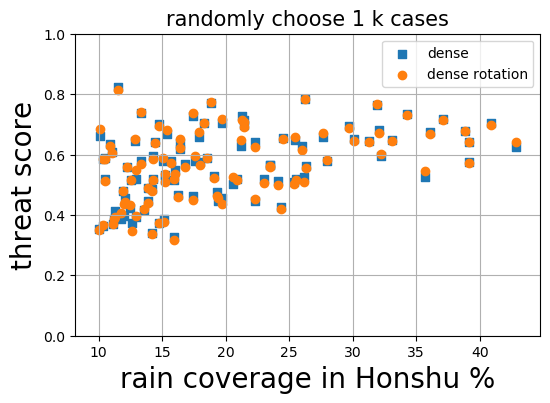

In [17]:
plt.figure(dpi=100)
plt.scatter(data.coverage, a_threat, marker = 's', label = "dense")
plt.scatter(data.coverage, b_threat, marker = 'o',label = "dense rotation")
plt.legend()
plt.title("randomly choose 1 k cases",fontsize= 15)
plt.xlabel("rain coverage in Honshu %",fontsize= 20)
plt.ylabel("threat score",fontsize= 20)
plt.ylim([0,1])
plt.grid()
plt.show()